# Setting up Workbook with packages and data and colors

In [54]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
print (sys.executable)
print("New working directory:", os.getcwd())
import rapidfuzz
from rapidfuzz import fuzz, process




c:\Users\abigail.weeks\AppData\Local\anaconda3\envs\cheshire\python.exe
New working directory: c:\Users\abigail.weeks\OneDrive - RMI\Documents\GitHub\Thesis\Thesis


In [55]:
import sys
!{sys.executable} -m pip install rapidfuzz

# Characterizing PJM Existing Generation by Fuel Type and Developer
### Open question: How much of the current capacity on the grid is ERIS??

In [56]:
PJM_existing_power_plants = pd.read_excel('Data/PJM_Power_Plants_6_13_2025.xlsx')
print(PJM_existing_power_plants.columns)
PJM_queued_plants=pd.read_excel('Data/PJM_Queue_Power_Plants_6_13_2025.xlsx')
print(PJM_queued_plants.columns)
PJM_queued_plants = PJM_queued_plants[PJM_queued_plants['Project Type'] != 'Merchant Transmission']
PJM_queued_plants['Fuel'] = PJM_queued_plants['Fuel'].replace('Solar,Storage,Hybrid', 'Solar & Storage')
PJM_queued_plants['Fuel'] = PJM_queued_plants['Fuel'].replace('Wind,Solar,Hybrid', 'Wind & Solar')
PJM_queued_plants['Fuel'] = PJM_queued_plants['Fuel'].replace('Solar,Wind,Hybrid', 'Wind & Solar')
PJM_nodes=pd.read_excel('node_states.xlsx')
print(PJM_queued_plants['Fuel'].dropna().unique())
fuel_color_map = {'Coal': '#000000',
 'Natural Gas': '#58585b',
 'Nuclear': '#73ff7c',
 'Other': 'pink',
 'Solar': '#FFCB00',
  'Solar ERIS': '#FFCB00',
 'Storage': 'yellow',
 'Storage ERIS': 'yellow',
 'Wind': '#3DADF2', 
 'Hydro': 'blue', 
 'Oil': 'red', 
 'Nuclear':'purple',
 'Offshore Wind': 'darkblue',
 'Solar & Storage': 'orange',
 'Wind & Solar': 'green', 
 'Biomass': 'brown'
 }

Index(['POWER_PLANT', 'PLANT_KEY', 'TECH_TYPE', 'OPER_CAPACITY_PLANT', 'OWNER',
       'OWNER_EIA_UTILITY_CODE', 'MO_1ST_UNIT_IN_SVC', 'YR_1ST_UNIT_IN_SVC',
       'FUEL_TYPE', 'ULT_PARENT'],
      dtype='object')
Index(['Project ID', 'Cycle', 'Stage', 'Name', 'Commercial Name', 'Developer',
       'State', 'County', 'Status', 'Project Type', 'Transmission Owner',
       'MFO', 'MW Energy', 'MW Capacity', 'MW In Service',
       'Capacity or Energy', 'Fuel', 'Submitted Date',
       'Requested In-Service Date', 'Revised In-Service Date',
       'Actual In-Service Date', 'Commercial Operation Milestone',
       'Backfeed Date', 'Test Energy Date', 'Last Updated', 'Withdrawn Date',
       'Withdrawn Remarks', 'Phase 1 SIS Report', 'Phase 1 SIS Report Status',
       'Phase 2 SIS Report', 'Phase 2 SIS Report Status', 'Phase 3 SIS Report',
       'Phase 3 SIS Report Status', 'GIA/WMPA Report',
       'GIA/WMPA Report Status', 'CSA/USCA Report', 'CSA/USCA Report Status',
       'Transmissio

In [57]:
#Figure Existing Capacity by Fuel Type
PJM_existing_power_plants['FUEL_TYPE'] = PJM_existing_power_plants['FUEL_TYPE'].replace({
    'Gas': 'Natural Gas',
    'Water': 'Hydro',
    'Energy Storage': 'Storage'
})
fuel_capacity = PJM_existing_power_plants.groupby('FUEL_TYPE').agg(
    OPER_CAPACITY_PLANT=('OPER_CAPACITY_PLANT', 'sum'),
    project_count=('POWER_PLANT', 'count')
).reset_index()

total_capacity = fuel_capacity['OPER_CAPACITY_PLANT'].sum()
total_capacity_gw = total_capacity / 1000
fuel_capacity['percent'] = fuel_capacity['OPER_CAPACITY_PLANT'] / total_capacity * 100
major = fuel_capacity[fuel_capacity['percent'] >= 1].copy()
minor = fuel_capacity[fuel_capacity['percent'] < 1].copy()
other_capacity_sum = minor['OPER_CAPACITY_PLANT'].sum()
other_project_count = minor['project_count'].sum()

if other_capacity_sum > 0:
    other_row = pd.DataFrame({
        'FUEL_TYPE': ['Other'],
        'OPER_CAPACITY_PLANT': [other_capacity_sum],
        'project_count': [other_project_count],
        'percent': [other_capacity_sum / total_capacity * 100]
    })
    major = pd.concat([major, other_row], ignore_index=True)
major['slice_text'] = major.apply(
    lambda row: f"{row['FUEL_TYPE']} {int(row['OPER_CAPACITY_PLANT']/1000):.0f} GW",
    axis=1
)

colors = major['FUEL_TYPE'].map(fuel_color_map).fillna('#CCCCCC').tolist()
fig = go.Figure(data=[go.Pie(
    labels=major['FUEL_TYPE'],               
    values=major['OPER_CAPACITY_PLANT'],
    text=major['slice_text'],                 
    textinfo='text',                          
    hovertemplate=(
        "<b>%{label}</b><br>" +              
        "%{value:,} MW<br>" +                 
        "%{customdata} projects<br>" +        
        "<extra></extra>"
    ),
    customdata=major['project_count'],       
    textfont=dict(size=16),
    marker=dict(colors=colors)
)])

fig.update_layout(
    title=f'Existing Operating Capacity by Fuel Type, PJM ({total_capacity_gw:,.0f}GW)',
    title_x=0.5,
    font=dict(size=14)
)

fig.show()



In [58]:
# Group and sum by fuel

PJM_queued_plants_by_fuel = PJM_queued_plants.groupby('Fuel')[['MW Capacity', 'MW Energy', 'MFO']].sum()

# Total MFO for percent calculation
total_mfo = PJM_queued_plants_by_fuel['MFO'].sum()
total_projects = PJM_queued_plants.shape[0]

# Split into major and minor (<1%) categories
PJM_queued_plants_by_fuel['percent'] = PJM_queued_plants_by_fuel['MFO'] / total_mfo * 100
major = PJM_queued_plants_by_fuel[PJM_queued_plants_by_fuel['percent'] >= 2].copy()
minor = PJM_queued_plants_by_fuel[PJM_queued_plants_by_fuel['percent'] < 2].copy()

# Add "Other" row if there are minor entries
if not minor.empty:
    other_row = pd.DataFrame({
        'MW Capacity': [minor['MW Capacity'].sum()],
        'MW Energy': [minor['MW Energy'].sum()],
        'MFO': [minor['MFO'].sum()],
        'percent': [minor['MFO'].sum() / total_mfo * 100]
    }, index=['Other'])
    major = pd.concat([major, other_row])

# Prepare data for the pie chart
labels = major.index
values = major['MFO'] / 1000  # Convert to GW
colors = [fuel_color_map.get(fuel, '#CCCCCC') for fuel in labels]

# Plot
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    name="Phase 3",
    marker_colors=colors,
    textinfo='percent',
   texttemplate='%{label}: <br> %{percent:.0%} (%{value:.0f} GW)',
    pull=[0] * len(labels)
)])
total_mfo_gw = total_mfo / 1000
fig.update_layout(
    title_text=f"Queued Capacity by Fuel  ({total_mfo_gw:,.0f} GW), {total_projects:,} projects",
    font=dict(size=18),
    title_x=0.5,
    showlegend=False,
    legend=dict(x=1.05, y=1, title="Fuel"),
    height=500
)

fig.show()


In [59]:
import plotly.graph_objects as go

# --- Prepare ERIS data ---
energy_plants = PJM_queued_plants[PJM_queued_plants['Capacity or Energy'] == 'Energy']
energy_by_fuel = energy_plants.groupby('Fuel')[['MW Capacity', 'MW Energy', 'MFO']].sum()
total_mfo_energy = energy_by_fuel['MFO'].sum()
energy_by_fuel['percent'] = energy_by_fuel['MFO'] / total_mfo_energy * 100
major_energy = energy_by_fuel[energy_by_fuel['percent'] >= 2].copy()
minor_energy = energy_by_fuel[energy_by_fuel['percent'] < 2].copy()
if not minor_energy.empty:
    other_row_energy = pd.DataFrame({
        'MW Capacity': [minor_energy['MW Capacity'].sum()],
        'MW Energy': [minor_energy['MW Energy'].sum()],
        'MFO': [minor_energy['MFO'].sum()],
        'percent': [minor_energy['MFO'].sum() / total_mfo_energy * 100]
    }, index=['Other'])
    major_energy = pd.concat([major_energy, other_row_energy])
labels_eris = major_energy.index
values_eris = major_energy['MFO'] / 1000  # GW
colors_eris = [fuel_color_map.get(fuel, '#CCCCCC') for fuel in labels_eris]
total_mfo_eris_gw = total_mfo_energy / 1000
total_projects_eris = energy_plants.shape[0]

# --- Prepare NRIS data ---
capacity_plants = PJM_queued_plants[PJM_queued_plants['Capacity or Energy'] == 'Capacity']
capacity_by_fuel = capacity_plants.groupby('Fuel')[['MW Capacity', 'MW Energy', 'MFO']].sum()
total_mfo_capacity = capacity_by_fuel['MFO'].sum()
capacity_by_fuel['percent'] = capacity_by_fuel['MFO'] / total_mfo_capacity * 100
major_capacity = capacity_by_fuel[capacity_by_fuel['percent'] >= 2].copy()
minor_capacity = capacity_by_fuel[capacity_by_fuel['percent'] < 2].copy()
if not minor_capacity.empty:
    other_row_capacity = pd.DataFrame({
        'MW Capacity': [minor_capacity['MW Capacity'].sum()],
        'MW Energy': [minor_capacity['MW Energy'].sum()],
        'MFO': [minor_capacity['MFO'].sum()],
        'percent': [minor_capacity['MFO'].sum() / total_mfo_capacity * 100]
    }, index=['Other'])
    major_capacity = pd.concat([major_capacity, other_row_capacity])
labels_nris = major_capacity.index
values_nris = major_capacity['MFO'] / 1000  # GW
colors_nris = [fuel_color_map.get(fuel, '#CCCCCC') for fuel in labels_nris]
total_mfo_nris_gw = total_mfo_capacity / 1000
total_projects_nris = capacity_plants.shape[0]

# --- Calculate relative sizes for domain scaling ---
total_gw = total_mfo_eris_gw + total_mfo_nris_gw
# Minimum domain width to avoid super small pies (optional)

eris_frac = total_mfo_eris_gw / total_gw
nris_frac = (total_mfo_nris_gw / total_gw)

# Normalize fractions so they sum to 1 (if min_domain_width caused overflow)
sum_frac = eris_frac + nris_frac
eris_frac /= sum_frac
nris_frac /= sum_frac

# --- Create figure with two pies scaled by their size ---
fig = go.Figure()

fig.add_trace(go.Pie(
    labels=labels_eris,
    values=values_eris,
    name="ERIS",
    marker_colors=colors_eris,
    textinfo='percent',
    texttemplate='%{label}: <br> %{percent:.0%} (%{value:.0f} GW)',
    domain=dict(x=[0, eris_frac], y=[0, 1]),
    hoverinfo='label+percent+value'
))

fig.add_trace(go.Pie(
    labels=labels_nris,
    values=values_nris,
    name="NRIS",
    marker_colors=colors_nris,
    textinfo='percent',
    texttemplate='%{label}: <br> %{percent:.0%} (%{value:.0f} GW)',
    domain=dict(x=[eris_frac, eris_frac + nris_frac], y=[0, 1]),
    hoverinfo='label+percent+value'
))

# --- Update layout ---
fig.update_layout(
    title_text=f"Queue Capacity by ERIS and NRIS <br>(ERIS: {total_mfo_eris_gw:,.0f} GW, {total_projects_eris:,} projects; NRIS: {total_mfo_nris_gw:,.0f} GW, {total_projects_nris:,} projects)",
    font=dict(size=16),
    title_x=0.5,
    height=600,
    showlegend=False,
    legend=dict(x=1.05, y=1, title="Fuel")
)

fig.show()


In [60]:


# Group and sum by Transmission Owner and Fuel
PJM_zone_fuel = PJM_queued_plants[PJM_queued_plants['Cycle'] == "TC1"]
PJM_zone_fuel = PJM_zone_fuel.groupby(['Transmission Owner', 'Fuel'])[['MW Capacity', 'MW Energy', 'MFO']].sum().reset_index()
print(PJM_zone_fuel["Fuel"].unique())
import plotly.graph_objects as go

# Pivot to wide format for stacked bar
bar_data = PJM_zone_fuel.pivot(index='Transmission Owner', columns='Fuel', values='MFO').fillna(0) / 1000  # GW

# Sort Transmission Owners by total MFO
bar_data = bar_data.loc[bar_data.sum(axis=1).sort_values(ascending=False).index]

# Define custom fuel stacking order (bottom to top)
fuel_order = [ 'Solar','Storage', 'Hybrid Solar Storage', 'Wind', 'Natural Gas','Wind & Solar', 'Offshore Wind']
fuel_order = [f for f in fuel_order if f in bar_data.columns]
bar_data = bar_data[fuel_order]

# Create stacked bar chart
fig = go.Figure()

for fuel in fuel_order:
    fig.add_trace(go.Bar(
        x=bar_data.index,
        y=bar_data[fuel],
        name=fuel,
        marker_color=fuel_color_map.get(fuel, '#CCCCCC')
    ))

fig.update_layout(
    barmode='stack',
    title='TC1 Queued Capacity by Transmission Owner and Fuel',
    yaxis_title='MFO (GW)',
    xaxis_title='Transmission Owner',
    font=dict(size=14),
    height=600,
    legend_traceorder="normal"
)

fig.show()


['Storage' 'Solar' 'Solar & Storage' 'Wind' 'Natural Gas' 'Wind & Solar'
 'Offshore Wind']


In [ ]:

# Sort dataframe
df_sorted = PJM_nodes.sort_values("Generation(GWh)", ascending=True).copy()

# Create subplots with 2 rows, shared x-axis
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("Generation (GWh)", "Generation Normalized (GWh / Installed Capacity)", "Congestion Costs")
)

# First row: Generation (GWh)
fig.add_trace(go.Bar(
    x=df_sorted["Name"],
    y=df_sorted["Generation(GWh)"],
    name="Generation (GWh)"
), row=1, col=1)

# Second row: Generation Normalized
fig.add_trace(go.Bar(
    x=df_sorted["Name"],
    y=df_sorted["Generation Normalized"],
    name="Generation Normalized"
), row=2, col=1)
fig.add_trace(go.Bar(
    x=df_sorted["Name"],
    y=df_sorted["congestion_cost"],
    name="Congestion Costs"
), row=3, col=1)

fig.update_layout(
    title_text="PJM Nodes: Generation and Generation Normalized",
    height=800,
    showlegend=False,
    xaxis3=dict(title="Node Name")  # only label x-axis on bottom
)

fig.show()



# --- Second grouped bar chart ---
fig2 = go.Figure()
fig2.add_trace(go.Bar(x=df_sorted["Name"], y=df_sorted["lmp"], name="LMP"))
fig2.add_trace(go.Bar(x=df_sorted["Name"], y=df_sorted["congestion_cost"], name="Congestion Cost"))
#fig2.add_trace(go.Bar(x=df_sorted["Name"], y=df_sorted["annual_growth_rate_ten_ year"], name="Annual Growth Rate (%)"))

fig2.update_layout(
    barmode='group',
    title="PJM Nodes: LMP, Congestion Cost",
    xaxis_title="Node Name",
    yaxis_title="Value",
    height=700
)
fig2.show()


### There are 3983 Ultimate Parents of 4865 owners, representing 16901 existing projects in PJM 
### Number of ULT_PARENTs with > 50 projects: 90, representing 48% of total capacity 
### owners do not mean developers though, so this might not be used at all


3983
4865
16901


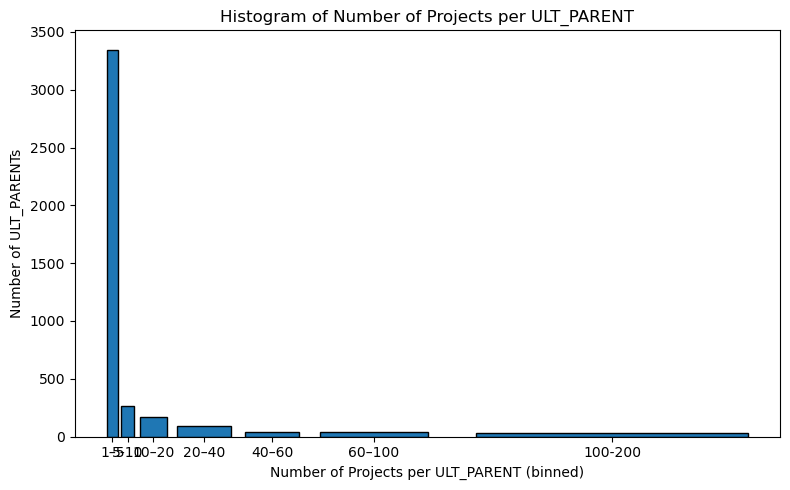

Number of ULT_PARENTs with > 50 projects: 90
Total capacity of these ULT_PARENTs: 1170028.73 MW
Percent of total capacity: 47.68%
Number of ULT_PARENTs with > 20 projects: 90
Percent of total capacity: 47.68%

Top ULT_PARENTs by number of projects and capacity:


In [62]:
unique_count_ULT_PARENT = PJM_existing_power_plants['ULT_PARENT'].nunique()
unique_count_OWNER = PJM_existing_power_plants['OWNER'].nunique()
unique_count_plant = PJM_existing_power_plants['POWER_PLANT'].nunique()
print(unique_count_ULT_PARENT)
print(unique_count_OWNER)
print(unique_count_plant)
ULT_PARENT_counts = PJM_existing_power_plants['ULT_PARENT'].value_counts()
bins = [1, 5, 10, 20, 40, 60, 100, 200]
labels = ['1–5', '5-10','10–20', '20–40', '40–60', '60–100', '100-200']

plt.figure(figsize=(8, 5))
n, bins_out, patches = plt.hist(ULT_PARENT_counts, bins=bins, edgecolor='black', rwidth=0.8)
bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.xticks(bin_centers, labels)
plt.xlabel('Number of Projects per ULT_PARENT (binned)')
plt.ylabel('Number of ULT_PARENTs')
plt.title('Histogram of Number of Projects per ULT_PARENT')
plt.tight_layout()
plt.show()

biggest_ULT_PARENTs = ULT_PARENT_counts[ULT_PARENT_counts > 50].index.tolist()
capacity_biggest_ULT_PARENTs_df = PJM_existing_power_plants[PJM_existing_power_plants['ULT_PARENT'].isin(biggest_ULT_PARENTs)]
capacity_biggest_ULT_PARENTs= capacity_biggest_ULT_PARENTs_df['OPER_CAPACITY_PLANT'].sum()
total_capacity = PJM_existing_power_plants['OPER_CAPACITY_PLANT'].sum()

# Percentage
percent_capacity_biggest_ULT_PARENTs = (capacity_biggest_ULT_PARENTs / total_capacity) * 100

# Output
print(f"Number of ULT_PARENTs with > 50 projects: {len(biggest_ULT_PARENTs)}")
print(f"Total capacity of these ULT_PARENTs: {capacity_biggest_ULT_PARENTs:.2f} MW")
print(f"Percent of total capacity: {percent_capacity_biggest_ULT_PARENTs:.2f}%")
summary_table = capacity_biggest_ULT_PARENTs_df.groupby('ULT_PARENT').agg(
    project_count=('POWER_PLANT', 'count'),
    total_capacity_MW=('OPER_CAPACITY_PLANT', 'sum')
).sort_values(by='total_capacity_MW', ascending=False)
summary_table = summary_table.reset_index()
summary_table['total_capacity_MW'] = summary_table['total_capacity_MW'].round(2)

# Print summary
print(f"Number of ULT_PARENTs with > 20 projects: {len(summary_table)}")
print(f"Percent of total capacity: {(summary_table['total_capacity_MW'].sum() / PJM_existing_power_plants['OPER_CAPACITY_PLANT'].sum()) * 100:.2f}%")
print("\nTop ULT_PARENTs by number of projects and capacity:")
import matplotlib.pyplot as plt

import plotly.graph_objects as go

# Group by ULT_PARENT and FUEL_TYPE to get both capacity and project count
grouped = capacity_biggest_ULT_PARENTs_df.groupby(['ULT_PARENT', 'FUEL_TYPE']).agg(
    OPER_CAPACITY_PLANT=('OPER_CAPACITY_PLANT', 'sum'),
    project_count=('POWER_PLANT', 'count')
).reset_index()


# # Loop through each parent to generate pie charts
# for parent in grouped['ULT_PARENT'].unique():
#     parent_data = grouped[grouped['ULT_PARENT'] == parent].copy()

#     # Create custom labels like "SOLAR (3 projects)"
#     parent_data['slice_text'] = parent_data.apply(
#         lambda row: f"{row['FUEL_TYPE']} ({row['project_count']} projects)", axis=1
#     )

#     fig = go.Figure(data=[go.Pie(
#         labels=parent_data['slice_text'],
#         values=parent_data['OPER_CAPACITY_PLANT'],
#         textinfo='label+percent',
#         hoverinfo='label+percent+value',
#         marker=dict(colors=parent_data['FUEL_TYPE'].map(fuel_color_map).fillna('#CCCCCC'))
#     )])

#     fig.update_layout(title_text=f'Fuel Mix for {parent}', title_x=0.5)
#     fig.show()



### TC1&TC2 has the developers listed, most projects are just one project per developer, in total there are 593 developers representing 963 projects, and there are 12 developers with more than 5 projects that in total represent about 18% of the queue's MW energy 


In [63]:


# Clean developer names (e.g. remove 'LLC', 'Inc')
import re

def clean_name(name):
    pattern = r'\b(solar|energy|storage|center|llc|inc)\b'
    return re.sub(pattern, '', name, flags=re.IGNORECASE).strip()
names = PJM_queued_plants['Developer'].dropna().unique()


cleaned_names = {name: clean_name(name) for name in names}

def startswith_bias(name1, name2):
    name1 = name1[:5]  # Only look at the first 10 characters
    name2 = name2[:5]
    
    score = fuzz.ratio(name1, name2)
    if name2.lower().startswith(name1.lower()) or name1.lower().startswith(name2.lower()):
        score += 15  # Add bonus for prefix match

    return min(score, 150)  # Cap score at 100

# Fuzzy matching with bias toward prefix
threshold = 70
similar_pairs = []

for i in range(len(names)):
    for j in range(i + 1, len(names)):
        name_i = cleaned_names[names[i]]
        name_j = cleaned_names[names[j]]
        score = startswith_bias(name_i, name_j)
        if score >= threshold:
            similar_pairs.append((names[i], names[j], score))

# Optional: Convert to DataFrame and export
similar_df = pd.DataFrame(similar_pairs, columns=['Name A', 'Name B', 'Score'])
similar_df.to_excel('similar_name_pairs_biased.xlsx', index=False)




df_similar = pd.DataFrame(similar_pairs, columns=["Name A", "Name B", "Similarity Score"])
df_similar.to_excel("similar_name_pairs.xlsx", index=False)
combined_names = pd.read_excel("similar_name_pairs_biased_manual_check.xlsx")
to_replace = combined_names[combined_names['Manual Check'] == 'Yes']
replacement_map = {}

for _, row in to_replace.iterrows():
    replacement_map[row['Name A']] = row['New Name']
    replacement_map[row['Name B']] = row['New Name']
PJM_queued_plants['Developer'] = PJM_queued_plants['Developer'].replace(replacement_map)
PJM_queued_plants_TC1=PJM_queued_plants[PJM_queued_plants['Cycle']=='TC1']
PJM_queued_plants_TC2=PJM_queued_plants[PJM_queued_plants['Cycle']=='TC2']
names = PJM_queued_plants['Developer'].dropna().unique()
# Get unique developer names from each cycle
tc1_developers = PJM_queued_plants_TC1['Developer'].dropna().unique()
tc2_developers = PJM_queued_plants_TC2['Developer'].dropna().unique()

# Convert to sets for comparison
set_tc1 = set(tc1_developers)
set_tc2 = set(tc2_developers)

# Developers in TC1 but not in TC2
only_in_tc1 = set_tc1 - set_tc2

# Developers in TC2 but not in TC1
only_in_tc2 = set_tc2 - set_tc1

# Developers in both
in_both = set_tc1 & set_tc2
print(f"Developers in TC1: {len(set_tc1)}")
print(f"Developers  in TC2: {len(set_tc2)}")
print(f"Developers only in TC1: {len(only_in_tc1)}")
print(f"Developers only in TC2: {len(only_in_tc2)}")
print(f"Developers in both: {len(in_both)}")
tc1_devs = set(PJM_queued_plants_TC1['Developer'].dropna().unique())
tc2_devs = set(PJM_queued_plants_TC2['Developer'].dropna().unique())

# Find overlap
devs_in_both = tc1_devs & tc2_devs

# Print sorted list
for dev in sorted(devs_in_both):
    print(dev)
unique_count_developer = PJM_queued_plants['Developer'].nunique()
unique_count_plant = PJM_queued_plants['Project ID'].nunique()
print(unique_count_developer)
print(unique_count_plant)
unique_count_developer= PJM_queued_plants['Developer'].value_counts()
biggest_developers = unique_count_developer[unique_count_developer > 6].index.tolist()
print(biggest_developers)
total_capacity=PJM_queued_plants['MW Energy'].sum()
capacity_biggest_developers_df = PJM_queued_plants[PJM_queued_plants['Developer'].isin(biggest_developers)]
capacity_biggest_developers= capacity_biggest_developers_df['MW Energy'].sum()
percent_capacity_biggest_developers = (capacity_biggest_developers / total_capacity) * 100
print(percent_capacity_biggest_developers)
import plotly.graph_objects as go

# Count number of projects per developer
project_counts = PJM_queued_plants['Developer'].value_counts()
import pandas as pd

# Get unique developers as a list or Series
unique_developers = PJM_queued_plants['Developer'].dropna().unique()

# Convert to DataFrame to export
df_unique_developers = pd.DataFrame(unique_developers, columns=['Developer'])

# Export to Excel file
df_unique_developers.to_excel('unique_developers.xlsx', index=False)


# Define bins manually
bins = {
    '1': (1, 1),
    '2–5': (2, 5),
    '6–10': (6, 10),
    '11–15': (11, 15),
    '>15': (16, float('inf'))
}

# Assign counts to bins
bin_counts = {label: 0 for label in bins}
for count in project_counts:
    for label, (low, high) in bins.items():
        if low <= count <= high:
            bin_counts[label] += 1
            break

# Plot using Plotly Graph Objects
fig = go.Figure(data=[go.Bar(
    x=list(bin_counts.keys()),
    y=list(bin_counts.values()),
    marker_color='steelblue',
    marker_line_color='black',
    marker_line_width=1,
    text=list(bin_counts.values()),
    textposition='auto'
)])

# Layout
fig.update_layout(
    title='Histogram of Project Counts per Developer (Custom Bins)',
    xaxis_title='Number of Projects per Developer',
    yaxis_title='Number of Developers',
    bargap=0.1,
    template='simple_white'
)

fig.show()
capacity_biggest_developers_df = PJM_queued_plants[
    PJM_queued_plants['Developer'].isin(biggest_developers)
]

# for dev in biggest_developers:
#     dev_df = capacity_biggest_developers_df[
#         capacity_biggest_developers_df['Developer'] == dev
#     ]

#     # Group by fuel: sum MW Energy and count projects
#     grouped = dev_df.groupby('Fuel').agg(
#         total_mw=('MW Energy', 'sum'),
#         project_count=('Project ID', 'count')
#     ).reset_index()

#     # Create label like: "Solar (4 projects)"
#     labels = grouped.apply(
#         lambda row: f"{row['Fuel']} ({row['project_count']} projects)", axis=1
#     )

#     fig = go.Figure(data=[go.Pie(
#         labels=labels,
#         values=grouped['total_mw'],
#         textinfo='label+value',
#         hovertemplate='%{label}<br>MW: %{value:,.1f}<extra></extra>',
#     )])

#     fig.update_layout(
#         title=f"{dev} – MW Energy by Fuel Type (n={len(dev_df)} projects)",
#         title_x=0.5
#     )

#     fig.show()


capacity_biggest_developers_df = PJM_queued_plants[
    PJM_queued_plants['Developer'].isin(biggest_developers)
]

# Step 1 & 2: total MW Energy and sorting
total_stats = capacity_biggest_developers_df.groupby('Developer').agg(
    total_mw_energy=('MW Energy', 'sum'),
    project_count=('Project ID', 'count')
).reset_index()

# Sort developers by MW Energy descending
developer_order = total_stats.sort_values('total_mw_energy', ascending=False)['Developer'].tolist()


# Assume capacity_biggest_developers_df and developer_order already defined

# Group by Developer and Fuel summing MW Energy
grouped = capacity_biggest_developers_df.groupby(['Developer', 'Fuel'])['MW Energy'].sum().reset_index()

# Make Developer categorical with desired order
grouped['Developer'] = pd.Categorical(grouped['Developer'], categories=developer_order, ordered=True)

fuel_types = grouped['Fuel'].unique()
colors=[fuel_color_map.get(fuel, '#888888') for fuel in grouped['Fuel']]

data = []
for fuel in fuel_types:
    fuel_data = grouped[grouped['Fuel'] == fuel]
    # Reindex to include all developers, fill missing with 0
    fuel_data = fuel_data.set_index('Developer').reindex(developer_order, fill_value=0).reset_index()
    
    trace = go.Bar(
        x=fuel_data['Developer'],
        y=fuel_data['MW Energy'],
        name=fuel, 
         marker_color=fuel_color_map.get(fuel, '#888888')  # fallback grey if missing
    )
    data.append(trace)

fig = go.Figure(data=data)

# Add project count annotations on top
for dev in developer_order:
    total_mw = grouped[grouped['Developer'] == dev]['MW Energy'].sum()
    proj_count = capacity_biggest_developers_df[capacity_biggest_developers_df['Developer'] == dev]['Project ID'].count()
    fig.add_annotation(
        x=dev,
        y=total_mw,
        text=f"{proj_count}",
        showarrow=False,
        yshift=10,
        font=dict(size=12, color='black')
    )
fig.update_layout(
    height=900,
    barmode='stack',
    title='MW Energy by Fuel Type for Each of the Biggest Developers (Sorted by Total MW Energy)',
    xaxis_title='Developer',
    yaxis_title='Total MW Energy',
    legend_title='Fuel Type',
    xaxis_tickangle=45,
    template='simple_white',
legend=dict(
        traceorder="normal",
        itemsizing='constant',
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02,
        bgcolor="rgba(255,255,255,0)",
        borderwidth=0,
        itemclick="toggleothers",  # Optional
        itemdoubleclick="toggle",  # Optional
        # crucial part:
        tracegroupgap=0 ))

fig.show()
print(percent_capacity_biggest_developers)


Developers in TC1: 167
Developers  in TC2: 381
Developers only in TC1: 129
Developers only in TC2: 343
Developers in both: 38
ACE
Amelia Energy Facility, LLC
Aurora
Bellflower
Big Shoulders Storage LLC
Blooming Grove Solar Energy Center LLC 
Blue Violet Energy, LLC
CPV  LLC
CPV LLC
Calpine
Chestnut LLC
Crossroads LLC
Dolphin Solar LLC
Exie Solar, LLC
Fountain Point Solar Energy LLC
Gipper
Goldfinch Solar, LLC
Heartland Solar LLC
Invenergy
Leeward Renewable Energy Development, LLC
MC Solar, LLC
McKean LLC
Mink Solar LLC
Minonk Solar, LLC
Morrisdale LLC
North Corners Energy, LLC
Oak Solar LLC
RWE LLC
Royerton Solar, LLC
Sand Dragon Energy LLC
Staunton Solar, LLC
Steward Creek Solar, LLC
TGE LLC
Two Oaks LLC
Urban Grid LLC
Virginia Electric and Power Company
Wapella Bluffs Wind Project, LLC
Williams County Solar, LLC
510
959
['Virginia Electric and Power Company', 'RWE LLC', 'Invenergy', 'ACE', 'Leeward Renewable Energy Development, LLC', 'Cardinal Energy Storage East, LLC', 'Steward Cree

23.49941140265857


In [64]:
# Step 0: Filter for energy-only plants
energy_plants = PJM_queued_plants[PJM_queued_plants['Capacity or Energy'] == 'Energy']
energy_plants.to_excel('energy_only_projects.xlsx', index=False)

# Step 1: Define "biggest" developers in energy queue (e.g. > 5 projects)
project_counts = energy_plants['Developer'].value_counts()
biggest_developers = project_counts[project_counts > 0].index.tolist()

# Step 2: Filter energy_plants to just those developers
capacity_biggest_developers_df = energy_plants[energy_plants['Developer'].isin(biggest_developers)]

# Step 3: Compute total energy MW and percent
total_capacity = energy_plants['MW Energy'].sum()
capacity_biggest_developers = capacity_biggest_developers_df['MW Energy'].sum()
percent_capacity_biggest_developers = (capacity_biggest_developers / total_capacity) * 100
print(f"Biggest developers account for {percent_capacity_biggest_developers:.2f}% of energy MW")

# Step 4: Aggregate MW Energy and project counts
total_stats = capacity_biggest_developers_df.groupby('Developer').agg(
    total_mw_energy=('MW Energy', 'sum'),
    project_count=('Project ID', 'count')
).reset_index()

# Step 5: Sort developers by energy capacity
developer_order = total_stats.sort_values('total_mw_energy', ascending=False)['Developer'].tolist()

# Step 6: Group by developer and fuel type
grouped = capacity_biggest_developers_df.groupby(['Developer', 'Fuel'])['MW Energy'].sum().reset_index()
grouped['Developer'] = pd.Categorical(grouped['Developer'], categories=developer_order, ordered=True)

# Step 7: Create bar chart
fuel_types = grouped['Fuel'].unique()
data = []
for fuel in fuel_types:
    fuel_data = grouped[grouped['Fuel'] == fuel]
    fuel_data = fuel_data.set_index('Developer').reindex(developer_order, fill_value=0).reset_index()

    data.append(go.Bar(
        x=fuel_data['Developer'],
        y=fuel_data['MW Energy'],
        name=fuel,
        marker_color=fuel_color_map.get(fuel, '#888888')
    ))

fig = go.Figure(data=data)

# Step 8: Add project count annotations
for dev in developer_order:
    total_mw = grouped[grouped['Developer'] == dev]['MW Energy'].sum()
    proj_count = capacity_biggest_developers_df[capacity_biggest_developers_df['Developer'] == dev]['Project ID'].count()
    fig.add_annotation(
        x=dev,
        y=total_mw,
        text=f"{proj_count}",
        showarrow=False,
        yshift=10,
        font=dict(size=12, color='black')
    )

# Step 9: Update layout
fig.update_layout(
    height=900,
    barmode='stack',
    title='MW Energy (Only "Energy" Projects) by Fuel Type for Biggest Developers (>5 projects)',
    xaxis_title='Developer',
    yaxis_title='Total MW Energy',
    legend_title='Fuel Type',
    xaxis_tickangle=45,
    template='simple_white',
    legend=dict(
        traceorder="normal",
        itemsizing='constant',
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02,
        bgcolor="rgba(255,255,255,0)",
        borderwidth=0,
        itemclick="toggleothers",
        itemdoubleclick="toggle",
        tracegroupgap=0
    )
)

fig.show()
energy_developers = set(energy_plants['Developer'].dropna().unique())

# Find all queued projects for those developers
all_projects_by_energy_devs = PJM_queued_plants[PJM_queued_plants['Developer'].isin(energy_developers)]

# Now exclude energy-only projects to get the non-energy ones
non_energy_projects_by_energy_devs = all_projects_by_energy_devs[
    all_projects_by_energy_devs['Capacity or Energy'] != 'Energy'
]
# Print how many developers have non-energy projects too
devs_with_non_energy = non_energy_projects_by_energy_devs['Developer'].nunique()
print(f"{devs_with_non_energy} of {len(energy_developers)} energy developers also have non-energy projects")

# Optional: see how many non-energy projects per developer
non_energy_stats = non_energy_projects_by_energy_devs.groupby('Developer').agg(
    non_energy_project_count=('Project ID', 'count'),
    non_energy_mw=('MW Capacity', 'sum')
).reset_index().sort_values('non_energy_project_count', ascending=False)

# Save to Excel if needed
non_energy_stats.to_excel('developers_with_non_energy_projects.xlsx', index=False)



Biggest developers account for 100.00% of energy MW


5 of 26 energy developers also have non-energy projects


In [65]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Filter only 'Energy' projects
energy_plants = PJM_queued_plants[PJM_queued_plants['Capacity or Energy'] == 'Energy']

# Step 2: Count number of energy-only projects per developer
project_counts = energy_plants['Developer'].value_counts()

# Step 3: Export unique developers (optional)
unique_developers = energy_plants['Developer'].dropna().unique()
df_unique_developers = pd.DataFrame(unique_developers, columns=['Developer'])
df_unique_developers.to_excel('unique_developers_energy_only.xlsx', index=False)

# Step 4: Define custom bins
bins = {
    '1': (1, 1),
    '2–5': (2, 5),
}

# Step 5: Count developers in each bin
bin_counts = {label: 0 for label in bins}
for count in project_counts:
    for label, (low, high) in bins.items():
        if low <= count <= high:
            bin_counts[label] += 1
            break

# Step 6: Plot using Plotly
fig = go.Figure(data=[go.Bar(
    x=list(bin_counts.keys()),
    y=list(bin_counts.values()),
    marker_color='lightgreen',
    marker_line_color='black',
    marker_line_width=1,
    text=list(bin_counts.values()),
    textposition='outside'
)])

fig.update_layout(
    title='Histogram of Energy-Only Project Counts per Developer (Custom Bins)',
    xaxis_title='Number of Energy Projects per Developer',
    yaxis_title='Number of Developers',
    bargap=0.1,
    template='simple_white',
    yaxis=dict(range=[0, 250]),
    height=700
)

fig.show()


In [66]:
PJM_queued_plants_serial=pd.read_excel('Data/PJM_Queue_Power_Plants_Serial_6_13_2025.xlsx')
print(PJM_queued_plants_serial.columns)
#there are no developers listed for the serial projects 

Index(['Project ID', 'Name', 'Commercial Name', 'State', 'County', 'Status',
       'Transmission Owner', 'MFO', 'MW Energy', 'MW Capacity',
       'MW In Service', 'Capacity or Energy', 'Project Type', 'Fuel',
       'Project (AC/DC)', 'Rights (MW)', 'Initial Study', 'Feasibility Study',
       'Feasibility Study Status', 'System Impact Study',
       'System Impact Study Status', 'Facilities Study',
       'Facilities Study Status',
       'Interim/Interconnection Service/Generation Interconnection Agreement',
       'Interim/Interconnection Service/Generation Interconnection Agreement Status',
       'Wholesale Market Participation Agreement',
       'Construction Service Agreement',
       'Construction Service Agreement Status',
       'Upgrade Construction Service Agreement',
       'Upgrade Construction Service Agreement Status', 'Backfeed Date',
       'Submitted Date', 'Long-Term Firm Service Start Date',
       'Long-Term Firm Service End Date', 'Test Energy Date',
       'Wi

In [67]:
import plotly.graph_objects as go

# Drop missing values
df = PJM_queued_plants.dropna(subset=['Fuel', 'MFO'])
print("Unique fuels in df:", df['Fuel'].unique())


# Calculate average MFO and project counts per fuel
stats = df.groupby('Fuel').agg(
    avg_mfo=('MFO', 'mean'),
    project_count=('MFO', 'count')
).reset_index()

# Sort by average MFO ascending
stats = stats.sort_values('avg_mfo')

# Sorted list of fuels
sorted_fuels = stats['Fuel'].tolist()

# Build box traces in sorted order
data = []
for fuel in sorted_fuels:
    fuel_mfo = df[df['Fuel'] == fuel]['MFO']
    trace = go.Box(
        y=fuel_mfo,
        name=fuel,
        boxpoints='outliers',
        marker=dict(size=4),
        marker_color=fuel_color_map.get(fuel, '#888888'),
        line=dict(width=1)
    )
    data.append(trace)

# Create figure
fig = go.Figure(data=data)

# Add project count annotations on x-axis
for i, row in stats.reset_index().iterrows():
    fig.add_annotation(
        x=i,
        y=df['MFO'].max() * 1.05,  # slightly above max y
        text=f"({row['project_count']})",
        showarrow=False,
        font=dict(size=12),
        xanchor='center'
    )

# Update layout
fig.update_layout(
    title="Distribution of Project Size by Fuel Type (project count)",
    yaxis_title="Maximum Facility Output (MW)",
    xaxis_title="Fuel Type",
    template="simple_white",
    margin=dict(t=80),  # add top margin to fit annotations
    yaxis=dict(range=[0, df['MFO'].max() * 1.15])
)

fig.show()


Unique fuels in df: ['Storage' 'Solar' 'Natural Gas' 'Solar & Storage' 'Offshore Wind' 'Wind'
 'Nuclear' 'Wind & Solar' 'Hydro' 'Biomass' 'Coal']


In [68]:
import plotly.graph_objects as go

# -- Base: All non-null Fuel and MFO rows --
df_all = PJM_queued_plants.dropna(subset=['Fuel', 'MFO'])

# -- Energy-only subset with relabeled Fuel --
energy_df = PJM_queued_plants[
    (PJM_queued_plants['Capacity or Energy'] == 'Energy') &
    (PJM_queued_plants['Fuel'].notna()) &
    (PJM_queued_plants['MFO'].notna())
].copy()

# Add "+ ERIS" to Fuel name for these rows
energy_df['Fuel'] = energy_df['Fuel'] + ' ERIS'

# -- Combine into one DataFrame --
df_combined = pd.concat([df_all, energy_df], ignore_index=True)

# -- Group and sort --
stats = df_combined.groupby('Fuel').agg(
    avg_mfo=('MFO', 'mean'),
    project_count=('MFO', 'count')
).reset_index()

stats = stats.sort_values('avg_mfo')
sorted_fuels = stats['Fuel'].tolist()

# -- Create boxplots in sorted order --
data = []
for fuel in sorted_fuels:
    fuel_mfo = df_combined[df_combined['Fuel'] == fuel]['MFO']
    trace = go.Box(
        y=fuel_mfo,
        name=fuel,
        boxpoints='outliers',
        marker=dict(size=4),
        marker_color=fuel_color_map.get(fuel.replace(' (ERIS)', ''), '#888888'),
        line=dict(width=1)
    )
    data.append(trace)

# -- Create plot --
fig = go.Figure(data=data)

# -- Add project count annotations --
# -- Add project count + mean MFO annotations --
for i, row in stats.reset_index(drop=True).iterrows():
    fig.add_annotation(
        x=i,
        y=df_combined['MFO'].max() * 1.05,
        text=f"({row['project_count']}) <br> {row['avg_mfo']:.0f} MW",
        showarrow=False,
        font=dict(size=18),
        xanchor='center',


        
    )

# -- Layout --
fig.update_layout(
    title="Distribution of Project Size by Fuel Type (Project Count) and Average Size",
    yaxis_title="Maximum Facility Output (MW)",
    xaxis_title="Fuel Type",
    template="simple_white",
    margin=dict(t=80),
    yaxis=dict(range=[0, df_combined['MFO'].max() * 1.15]),
    height=800,
    font=dict(size=20),
)

fig.show()


In [69]:
import pandas as pd
import plotly.graph_objects as go

# --- Total MFO by Fuel ---
fuel_color_map = {'Coal': '#000000',
 'Natural Gas': '#58585b',
 'Nuclear': '#73ff7c',
 'Other': 'pink',
 'Solar': '#FFCB00',
 'Storage': 'yellow',
 'Wind': '#3DADF2', 
 'Water': 'blue', 
 'Oil': 'red', 
 'Nuclear':'purple',
 'Offshore Wind': 'darkblue'
 }

df = PJM_queued_plants.dropna(subset=['Fuel', 'MFO'])
total_mfo_by_fuel = df.groupby('Fuel')['MFO'].sum().reset_index()

total_sum = total_mfo_by_fuel['MFO'].sum()
total_mfo_by_fuel['percent'] = total_mfo_by_fuel['MFO'] / total_sum

mask = total_mfo_by_fuel['percent'] < 0.01
other_sum = total_mfo_by_fuel.loc[mask, 'MFO'].sum()

filtered = total_mfo_by_fuel.loc[~mask].copy()
colors = [fuel_color_map.get(fuel, '#888888') for fuel in filtered['Fuel']]

if other_sum > 0:
    other_row = pd.DataFrame([{'Fuel': 'Other', 'MFO': other_sum, 'percent': other_sum / total_sum}])
    filtered = pd.concat([filtered, other_row], ignore_index=True)

fig = go.Figure(go.Pie(
    labels=filtered['Fuel'],
    values=filtered['MFO'],
    hoverinfo='label+percent+value',
    texttemplate='%{label} %{percent:.0%}',
    textfont_size=14, 
    marker=dict(colors=colors)
))

fig.update_layout(
    title='Total MFO by Fuel Type (Grouping <1% as Other)',
    template='simple_white'
)

fig.show()

# --- Project Count by Fuel ---

df = PJM_queued_plants.dropna(subset=['Fuel', 'Project ID'])
project_counts = df.groupby('Fuel')['Project ID'].nunique().reset_index()

total_projects = project_counts['Project ID'].sum()
project_counts['percent'] = project_counts['Project ID'] / total_projects

mask = project_counts['percent'] < 0.01
other_count = project_counts.loc[mask, 'Project ID'].sum()

filtered_proj = project_counts.loc[~mask].copy()
colors = [fuel_color_map.get(fuel, '#888888') for fuel in filtered_proj['Fuel']]

if other_count > 0:
    other_row = pd.DataFrame([{'Fuel': 'Other', 'Project ID': other_count, 'percent': other_count / total_projects}])
    filtered_proj = pd.concat([filtered_proj, other_row], ignore_index=True)

fig = go.Figure(go.Pie(
    labels=filtered_proj['Fuel'],
    values=filtered_proj['Project ID'],
    hoverinfo='label+percent+value',
    texttemplate='%{label} %{percent:.0%}',
    textfont_size=14,
    marker=dict(colors=colors)
))

fig.update_layout(
    title='Project Count by Fuel Type (Grouping <1% as Other)',
    template='simple_white'
)

fig.show()
unique_fuels = PJM_queued_plants['Fuel'].dropna().unique()
print(sorted(unique_fuels))


['Biomass', 'Coal', 'Hydro', 'Natural Gas', 'Nuclear', 'Offshore Wind', 'Solar', 'Solar & Storage', 'Storage', 'Wind', 'Wind & Solar']


In [70]:

# Define years and LMP values
years = list(range(2000, 2024 + 1))
lmp_values = [
    35.13, 36.01, 31.80, 41.43, 42.87, 62.50, 51.33, 57.88, 70.25, 38.82, 47.65,
    45.19, 34.55, 38.93, 53.62, 36.73, 29.68, 30.85, 37.97, 27.23, 21.40,
    39.37, 75.44, 31.93, 33.79
]

# Create the DataFrame
df = pd.DataFrame({
    'year': years,
    'load_weighted_lmp': lmp_values
})

# Plot with Plotly
fig = px.line(
    df,
    x='year',
    y='load_weighted_lmp',
    title='Load-Weighted LMP by Year in PJM',
    markers=True,
    labels={'year': 'Year', 'load_weighted_lmp': 'LMP ($/MWh)'}
)

fig.update_layout(
    template='plotly_white',
    yaxis_tickformat=".0f",
    font=dict(size=14),
    title_x=0.5
)

fig.show()


In [71]:
import pandas as pd
import plotly.express as px

# Load the Excel file
df = pd.read_excel('Table_7_40_MMU.xlsx')

# Define quartiles in desired order
quartile_order = ['First Quartile', 'Median', 'Third Quartile']

# Build long-format data
records = []

for i, tech in enumerate(df['Technology']):
    for quartile in quartile_order:
        for rev_type, prefix in [
            ('Energy and ancillary service net revenue', 'Energy and ancillary service net revenue'),
            ('Capacity revenue', 'Capacity revenue')
        ]:
            records.append({
                'Technology': tech,
                'revenue_type': rev_type,
                'quartile': quartile,
                'revenue': df.loc[i, f'{prefix} {quartile.lower()}']
            })

# Create long-format dataframe
df_long = pd.DataFrame(records)

# Create composite x-axis grouped by technology first, then quartile
df_long['x'] = df_long['Technology'] + ' - ' + df_long['quartile']

# Define categorical x-axis order
unique_techs = df['Technology'].unique()
ordered_x = [f'{tech} - {q}' for tech in unique_techs for q in quartile_order]
df_long['x'] = pd.Categorical(df_long['x'], categories=ordered_x, ordered=True)

# Plot with Plotly
fig = px.bar(
    df_long,
    x='x',
    y='revenue',
    color='revenue_type',
    barmode='stack',
    title='Capacity and Energy Revenue by Technology and Quartile',
    labels={'x': 'Technology and Quartile', 'revenue': 'Revenue ($/ICAP MW-Year)'}
)

fig.update_layout(
    template='plotly_white',
    font=dict(size=14),
    title_x=0.5,
    yaxis_tickformat=',.0f',
    legend_title_text='Revenue Type',
    xaxis_tickangle=45
)

fig.show()

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load data
df = pd.read_excel('Table_7_40_MMU.xlsx')
technologies_to_plot = ["Combustion Turbine", "Combined Cycle", "Wind", "Solar"]
df = df[df['Technology'].isin(technologies_to_plot)]

# Revenue calculations
df['Energy_kW'] = df['Energy and ancillary service net revenue median'] / 1000
df['Capacity_kW'] = df['Capacity revenue median'] / 1000
df['REC_kW']=df['REC']/1000
df['Total_kW'] = df['Energy_kW'] + df['Capacity_kW']+df['REC_kW']
df['LCOE_kW'] = df['LCOE'] / 1000
df['Total Installed Capacity']=df['Total Installed Capacity ']
df_sorted = df.sort_values('Total_kW')

# Color map
color_map = {
    'Energy and ancillary service net revenue': '#FFA726',  # orange
    'Capacity revenue': '#42A5F5',                          # blue
    'REC revenue': '#66BB6A'                                # green
}

# Subplots setup
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.12,
    subplot_titles=[
        "Capacity Revenue and Net Energy Revenue by Technology (Median, 2024 PJM)",
        "Installed Capacity by Technology"
    ]
)

# --- Top subplot: stacked revenue bars ---
for rev_type in ['Energy and ancillary service net revenue', 'Capacity revenue', 'REC revenue']:
    y_values = df_sorted.apply(
        lambda row: row['Energy_kW'] if rev_type == 'Energy and ancillary service net revenue'
        else row['Capacity_kW'] if rev_type == 'Capacity revenue'
        else row['REC_kW'],
        axis=1
    )

    fig.add_trace(go.Bar(
        x=df_sorted['Technology'],
        y=y_values,
        name=rev_type,
        marker_color=color_map.get(rev_type),
        showlegend=True
    ), row=1, col=1)

# Add LCOE lines and annotations
for _, row in df_sorted.iterrows():
    fig.add_shape(
        type='line',
        x0=row['Technology'],
        x1=row['Technology'],
        y0=0,
        y1=row['LCOE_kW'],
        line=dict(color='red', width=2, dash='dot'),
        xref='x',
        yref='y',
        row=1,
        col=1
    )
    fig.add_annotation(
        x=row['Technology'],
        y=row['LCOE_kW'],
        text=f"${row['LCOE_kW']:.0f}",
        showarrow=False,
        yshift=8,
        font=dict(color='red', size=12),
        row=1,
        col=1
    )

# Add percentage annotations above bars
for _, row in df_sorted.iterrows():
    total = row['Total_kW']
    if total == 0:
        continue
    energy_pct = round(100 * row['Energy_kW'] / total, 2)
    capacity_pct = round(100 * row['Capacity_kW'] / total, 2)
    rec_pct=round(100*row['REC_kW']/total,2)
    label_text = (
        f'<span style="color:{color_map["Energy and ancillary service net revenue"]}">'
        f'{energy_pct:.2f}%</span> / '
        f'<span style="color:{color_map["Capacity revenue"]}">{capacity_pct:.2f}%</span>/'
        f'<span style="color:{color_map["REC revenue"]}">{rec_pct:.2f}%</span>'
    )

    fig.add_annotation(
        x=row['Technology'],
        y=row['Total_kW'],
        text=label_text,
        showarrow=False,
        yshift=10,
        font=dict(size=12),
        row=1,
        col=1
    )

# Dummy trace for LCOE legend
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='lines',
    line=dict(color='red', width=2, dash='dot'),
    name='Levelized Cost of New Unit ($/kW-Year)'
), row=1, col=1)

# --- Bottom subplot: Installed Capacity (MW) ---
fig.add_trace(go.Bar(
    x=df_sorted['Technology'],
    y=df_sorted['Total Installed Capacity'],
    marker_color='gray',
    name='Installed Capacity (MW)',
    showlegend=False
), row=2, col=1)

# Final layout
fig.update_layout(
    barmode='stack',
    template='plotly_white',
    font=dict(size=14),
    title_x=0.5,
    yaxis_tickformat=',.0f',
    legend_title_text='Revenue or Cost Type',
    height=800
)
fig.update_xaxes(showticklabels=True, row=1, col=1)
fig.update_yaxes(title_text='Revenue ($/kW-Year)', row=1, col=1)
fig.update_yaxes(title_text='Installed Capacity (GW)', row=2, col=1)
fig.update_xaxes(title_text='Technology', tickangle=0, row=2, col=1)

fig.show()


"energy net revenues include day-ahead and 
balancing market energy revenues, less short run 
marginal costs, plus any applicable day-ahead or 
balancing operating reserve credits (uplift)"